In [2]:
n_fwd_days = 5 # number of days to compute returns over

percentile = 25 # target percetile of the prediction

from quantopian.pipeline.filters import QTradableStocksUS
universe = QTradableStocksUS()

import pandas as pd
start = pd.Timestamp("2018-05-26")
end = pd.Timestamp("2018-09-26")


from quantopian.pipeline.factors import Returns


def make_factors():
    def Asset_Growth_1d():
        return Returns(window_length=2)
    def Asset_Growth_2d():
        return Returns(window_length=3)
    def Asset_Growth_3d():
        return Returns(window_length=4)
    def Asset_Growth_4d():
        return Returns(window_length=5)
    def Asset_Growth_5d():
        return Returns(window_length=6)
    def Asset_Growth_6d():
        return Returns(window_length=7)
    def Asset_Growth_7d():
        return Returns(window_length=8)
    def Asset_Growth_8d():
        return Returns(window_length=9)
    def Asset_Growth_9d():
        return Returns(window_length=10)
    def Asset_Growth_10d():
        return Returns(window_length=11) 
    
    
    all_factors = {
        'Asset Growth 1d': Asset_Growth_1d,
        'Asset Growth 2d': Asset_Growth_2d,
        'Asset Growth 3d': Asset_Growth_3d,
        'Asset Growth 4d': Asset_Growth_4d,
        'Asset Growth 5d': Asset_Growth_5d,
        'Asset Growth 6d': Asset_Growth_6d,
        'Asset Growth 7d': Asset_Growth_7d,
        'Asset Growth 8d': Asset_Growth_8d,
        'Asset Growth 9d': Asset_Growth_9d,
        'Asset Growth 10d': Asset_Growth_10d
    }     

    return all_factors

factors = make_factors()

factors

{'Asset Growth 10d': <function __main__.Asset_Growth_10d>,
 'Asset Growth 1d': <function __main__.Asset_Growth_1d>,
 'Asset Growth 2d': <function __main__.Asset_Growth_2d>,
 'Asset Growth 3d': <function __main__.Asset_Growth_3d>,
 'Asset Growth 4d': <function __main__.Asset_Growth_4d>,
 'Asset Growth 5d': <function __main__.Asset_Growth_5d>,
 'Asset Growth 6d': <function __main__.Asset_Growth_6d>,
 'Asset Growth 7d': <function __main__.Asset_Growth_7d>,
 'Asset Growth 8d': <function __main__.Asset_Growth_8d>,
 'Asset Growth 9d': <function __main__.Asset_Growth_9d>}

In [3]:
from quantopian.pipeline import Pipeline

from quantopian.pipeline.data.builtin import USEquityPricing


def make_history_pipeline(factors, universe, n_fwd_days=5):
    
    # Build dictionary of factors names and definitions used to calculate the information of the input variables 
    factor_ranks = {name: f() for name, f in factors.iteritems()}
    
    # Add to the dictionary the factor name and definitios used to calculate the information of the target variable
    factor_ranks['Returns'] = Returns(inputs=[USEquityPricing.open],window_length=n_fwd_days)
    
    print factor_ranks
    
    pipe = Pipeline(screen=universe, columns=factor_ranks)
    
    return pipe

history_pipe = make_history_pipeline(factors, universe, n_fwd_days=n_fwd_days)

history_pipe

{'Asset Growth 4d': Returns([EquityPricing.close], 5), 'Asset Growth 5d': Returns([EquityPricing.close], 6), 'Asset Growth 7d': Returns([EquityPricing.close], 8), 'Asset Growth 3d': Returns([EquityPricing.close], 4), 'Returns': Returns([EquityPricing<US>.open], 5), 'Asset Growth 8d': Returns([EquityPricing.close], 9), 'Asset Growth 2d': Returns([EquityPricing.close], 3), 'Asset Growth 9d': Returns([EquityPricing.close], 10), 'Asset Growth 10d': Returns([EquityPricing.close], 11), 'Asset Growth 6d': Returns([EquityPricing.close], 7), 'Asset Growth 1d': Returns([EquityPricing.close], 2)}


In [4]:
from quantopian.research import run_pipeline

from time import time
start_timer = time()
results = run_pipeline(history_pipe, start_date=start, end_date=end)
results.index.names = ['date', 'security']
end_timer = time()
print "Time to run pipeline %.2f secs" % (end_timer - start_timer)

Time to run pipeline 65.58 secs


In [5]:
import numpy as np

training = 0.75


results_wo_returns = results.copy()
returns = results_wo_returns.pop('Returns')
Y = returns.unstack().values
X = results_wo_returns.to_panel() 
X = X.swapaxes(2, 0).swapaxes(0, 1).values # (factors, time, stocks) -> (time, stocks, factors)


n_time, n_stocks, n_factors = X.shape
train_size = np.int16(np.round(training * n_time))
X_train_aux, Y_train_aux = X[:train_size, ...], Y[:train_size]
X_test_aux, Y_test_aux = X[(train_size+n_fwd_days):, ...], Y[(train_size+n_fwd_days):]

In [6]:
n_time, n_stocks, n_factors = X_test_aux.shape
print X_test_aux.shape, n_time* n_stocks

(16, 2293, 10) 36688


In [7]:
X_test_aux[0][0]

array([ 0.04198113, -0.012958  ,  0.00090621, -0.00360848,  0.00821543,
        0.00135993, -0.00607424,  0.04050871,  0.03031716,  0.02458256])

In [8]:
def shift_recode_mask_data(X, Y, upper_percentile=100-percentile, lower_percentile=percentile, n_fwd_days=1):
    # Shift X to match factors at t to returns at t+n_fwd_days (we want to predict future returns after all)
    shifted_X = np.roll(X, n_fwd_days+1, axis=0)
    
    # Slice off rolled elements
    X = shifted_X[n_fwd_days+1:]
    Y = Y[n_fwd_days+1:]
    
    n_time, n_stocks, n_factors = X.shape
    
    # Look for biggest up and down movers
    upper = np.nanpercentile(Y, upper_percentile, axis=1)[:, np.newaxis]
    lower = np.nanpercentile(Y, lower_percentile, axis=1)[:, np.newaxis]
  
    upper_mask = (Y >= upper)
    lower_mask = (Y <= lower)
    
    mask = upper_mask | lower_mask # This also drops nans
    mask = mask.flatten()
    
    # Only try to predict whether a stock moved up/down relative to other stocks
    Y_binary = np.zeros(n_time * n_stocks)
    Y_binary[upper_mask.flatten()] = 1
    Y_binary[lower_mask.flatten()] = -1
    
    # Flatten X
    X = X.reshape((n_time * n_stocks, n_factors))

    # Drop stocks that did not move much (i.e. are not in the upper_percentile or the lower_percentile )
    X = X[mask]
    Y_binary = Y_binary[mask]
    
    # Drop stocks with nan returns
    masknan=  ~np.isnan(X).any(axis=1)
    X = X[masknan]
    Y_binary = Y_binary[masknan]
    
    return X, Y_binary

In [9]:
X_train, Y_train = shift_recode_mask_data(X_train_aux, Y_train_aux, n_fwd_days=n_fwd_days)
X_test, Y_test = shift_recode_mask_data(X_test_aux, Y_test_aux, n_fwd_days=n_fwd_days, 
                                             lower_percentile=40, 
                                             upper_percentile=60)

X_train.shape, X_test.shape

((63136, 10), (17509, 10))

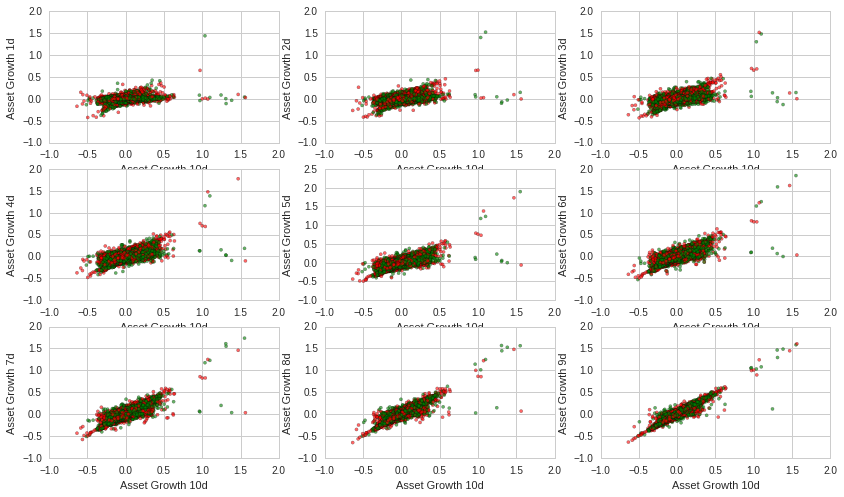

In [10]:
import matplotlib.pyplot as plt

X = X_train
Y = Y_train
color = []
color = ['green' if v == 1 else 'red' for v in Y] 


plt.subplot(3, 3, 1)
plt.scatter(X[:, 0], X[:, 1], c=color, alpha= 0.6, s=10, edgecolor='k') 
plt.xlabel('Asset Growth 10d')
plt.ylabel('Asset Growth 1d')

plt.subplot(3, 3, 2)
plt.scatter(X[:, 0], X[:, 2], c=color, alpha= 0.6, s=10, edgecolor='k')  
plt.xlabel('Asset Growth 10d')
plt.ylabel('Asset Growth 2d')

plt.subplot(3, 3, 3)
plt.scatter(X[:, 0], X[:, 3], c=color, alpha= 0.6, s=10, edgecolor='k') 
plt.xlabel('Asset Growth 10d')
plt.ylabel('Asset Growth 3d')

plt.subplot(3, 3, 4)
plt.scatter(X[:, 0], X[:, 4], c=color, alpha= 0.6, s=10, edgecolor='k') 
plt.xlabel('Asset Growth 10d')
plt.ylabel('Asset Growth 4d')

plt.subplot(3, 3, 5)
plt.scatter(X[:, 0], X[:, 5], c=color, alpha= 0.6, s=10, edgecolor='k') 
plt.xlabel('Asset Growth 10d')
plt.ylabel('Asset Growth 5d')

plt.subplot(3, 3, 6)
plt.scatter(X[:, 0], X[:, 6], c=color, alpha= 0.6, s=10, edgecolor='k') 
plt.xlabel('Asset Growth 10d')
plt.ylabel('Asset Growth 6d')

plt.subplot(3, 3, 7)
plt.scatter(X[:, 0], X[:, 7], c=color, alpha= 0.6, s=10, edgecolor='k')  
plt.xlabel('Asset Growth 10d')
plt.ylabel('Asset Growth 7d')

plt.subplot(3, 3, 8)
plt.scatter(X[:, 0], X[:, 8], c=color, alpha= 0.6, s=10, edgecolor='k') 
plt.xlabel('Asset Growth 10d')
plt.ylabel('Asset Growth 8d')

plt.subplot(3, 3, 9)
plt.scatter(X[:, 0], X[:, 9], c=color, alpha= 0.6, s=10, edgecolor='k') 
plt.xlabel('Asset Growth 10d')
plt.ylabel('Asset Growth 9d')

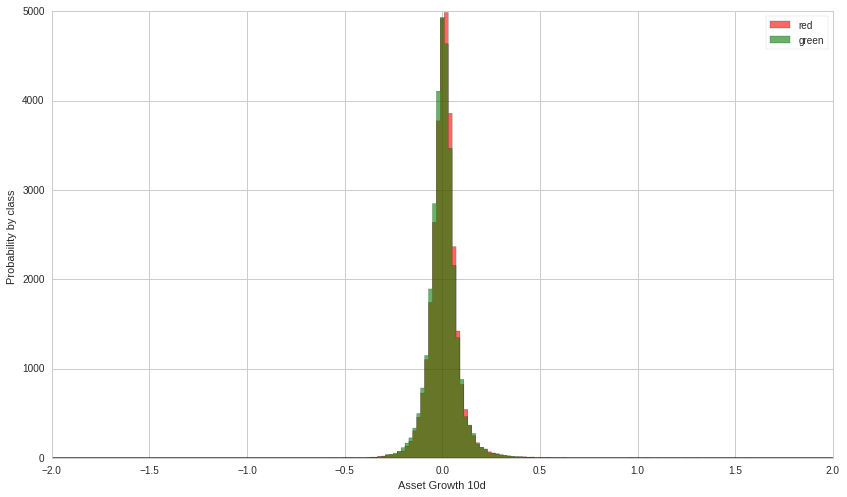

In [11]:
x = X[:,0]

mask = (Y == 1)
xg = x[mask]

mask = (Y == -1)
xr = x[mask]

xlim = (-2, 2)
bins = np.linspace(xlim[0], xlim[1], 200)

plt.hist(xr, bins, alpha=0.6,  histtype='stepfilled', label='red',  color='red')
plt.hist(xg, bins, alpha=0.6,  histtype='stepfilled', label='green', color='green' )
plt.legend(loc='upper right')
plt.xlabel('Asset Growth 10d')
plt.ylabel('Probability by class ')
plt.show()

In [12]:
import pandas as pd
labels = ['Asset Growth 10d',
          'Asset Growth 1d',
          'Asset Growth 2d',
          'Asset Growth 3d',
          'Asset Growth 4d',
          'Asset Growth 5d',
          'Asset Growth 6d',
          'Asset Growth 7d',
          'Asset Growth 8d',
          'Asset Growth 9d']      
df = pd.DataFrame(X_train, columns=labels)
df['target'] = Y_train
df.sample(20)

,Asset Growth 10d,Asset Growth 1d,Asset Growth 2d,Asset Growth 3d,Asset Growth 4d,Asset Growth 5d,Asset Growth 6d,Asset Growth 7d,Asset Growth 8d,Asset Growth 9d,target
7897,-0.032895,-0.013423,-0.010101,0.006849,-0.010101,-0.031301,-0.020000,-0.010101,-0.039216,-0.045455,1.0
28124,-0.067298,0.025434,0.023855,0.033800,-0.024918,-0.008569,0.012750,0.005669,-0.037613,-0.042806,-1.0
30076,-0.032012,0.001044,-0.006512,-0.003858,0.011908,0.010842,0.008412,0.012977,0.010385,0.009322,1.0
18641,-0.019376,-0.002850,-0.004454,-0.002479,-0.017820,-0.012880,-0.023659,-0.032115,-0.037210,-0.028727,1.0
30801,0.015467,-0.002619,0.016551,0.025310,0.060134,0.062500,0.060134,0.039301,0.025310,0.012766,-1.0
36732,-0.002327,-0.003717,0.007046,-0.005566,-0.005104,-0.017865,-0.009700,-0.003717,-0.001862,-0.007407,1.0
60515,-0.088278,0.019165,-0.003191,-0.034261,-0.049683,-0.102681,-0.102251,-0.092691,-0.095100,-0.083822,-1.0
22160,-0.138928,-0.086078,-0.156768,-0.215296,-0.212258,-0.227704,-0.215296,-0.226236,-0.200916,-0.205078,1.0
6499,0.017903,0.010239,0.011390,0.014857,0.003390,0.024931,0.023753,0.015581,0.015581,0.019651,-1.0
1439,0.034545,0.003140,0.007005,0.018420,0.022768,0.028255,0.036783,0.043936,0.043557,0.043747,-1.0


import seaborn as sns
sns.set()
palette = ['#FF0000','#00FF00']
sns.set_palette(palette)
sns.pairplot(df, vars=labels,  hue='target', diag_kind = 'kde', plot_kws = {'alpha': 0.6, 's': 10, 'edgecolor': 'k'});

In [23]:
start_timer = time()

# Train classifier
from sklearn.naive_bayes import GaussianNB
clf = GaussianNB()
clf.fit(X_train[:10000], Y_train[:10000]);

from sklearn.svm import SVC # "Support vector classifier"
model = SVC(kernel='rbf')
model.fit(X_train[:10000], Y_train[:10000])


model2 = SVC(kernel='linear')
model2.fit(X_train[:10000], Y_train[:10000])

end_timer = time()
print "Time to train : %0.2f secs" % (end_timer - start_timer)

SandboxViolation: Importing MLPClassifier from sklearn.neural_network raised an ImportError. No modules or attributes with a similar name were found.

In [14]:
from sklearn import metrics

Y_pred = clf.predict(X_train)
Y_pred2 = model.predict(X_train)
Y_pred3 = model2.predict(X_train)
print('Accuracy on train set = {:.2f}%'.format(metrics.accuracy_score(Y_train, Y_pred) * 100))
print('Accuracy on train set = {:.2f}%'.format(metrics.accuracy_score(Y_train, Y_pred2) * 100))
print('Accuracy on train set = {:.2f}%'.format(metrics.accuracy_score(Y_train, Y_pred3) * 100))

Accuracy on train set = 50.86%
Accuracy on train set = 50.15%
Accuracy on train set = 50.05%


In [15]:
# Predict!
Y_pred = clf.predict(X_test)
Y_pred2 = model.predict(X_test)
Y_pred3 = model2.predict(X_test)

Y_pred_prob = clf.predict_proba(X_test)
#Y_pred_prob2 = model.predict_proba(X_test)
#Y_pred_prob3 = model2.predict_proba(X_test)

In [16]:
print 'Predictions:', Y_pred
print 'Probabilities of class == 1:', Y_pred_prob[:, 1] * 100
print 'Predictions2:', Y_pred2
print 'Predictions3:', Y_pred3
a = 0
for i in range (0,len(Y_pred)):
    if Y_pred[i] != Y_pred2[i]:
        a = a+1
        
print a

Predictions: [-1. -1. -1. ...,  1. -1.  1.]
Probabilities of class == 1: [ 31.56105695  28.70476128  34.36817661 ...,  56.40472609  34.46647853
  82.66317779]
Predictions2: [-1. -1. -1. ..., -1. -1. -1.]
Predictions3: [-1. -1. -1. ..., -1. -1. -1.]
3066


In [17]:
print('Accuracy on test set = {:.2f}%'.format(metrics.accuracy_score(Y_test, Y_pred) * 100))
print('Log-loss = {:.5f}'.format(metrics.log_loss(Y_test, Y_pred_prob)))

Accuracy on test set = 51.48%
Log-loss = 0.81167


In [18]:
from sklearn.neighbors import KNeighborsClassifier  
classifier = KNeighborsClassifier(n_neighbors=5)  
classifier.fit(X_train, Y_train)
y_pred = classifier.predict(X_test)  

In [19]:
print('Accuracy on test set = {:.2f}%'.format(metrics.accuracy_score(Y_test, y_pred) * 100))

Accuracy on test set = 49.65%


In [20]:
from sklearn.metrics import classification_report, confusion_matrix  
print(confusion_matrix(Y_test, y_pred))  
print(classification_report(Y_test, y_pred))

[[4570 4181]
 [4634 4124]]
             precision    recall  f1-score   support

       -1.0       0.50      0.52      0.51      8751
        1.0       0.50      0.47      0.48      8758

avg / total       0.50      0.50      0.50     17509



In [43]:
len(Y_train)

63136

In [46]:
Y_train.shape

(63136,)

In [66]:
import numpy as np

class NeuralNetwork():
    
    def __init__(self):
        # seeding for random number generation
        np.random.seed(1)
        
        #converting weights to a 3 by 1 matrix with values from -1 to 1 and mean of 0
        self.synaptic_weights = 2 * np.random.random((63136, 1)) - 1

    def sigmoid(self, x):
        #applying the sigmoid function
        return 1 / (1 + np.exp(-x))

    def sigmoid_derivative(self, x):
        #computing derivative to the Sigmoid function
        return x * (1 - x)

    def train(self, training_inputs, training_outputs, training_iterations):
        
        #training the model to make accurate predictions while adjusting weights continually
        for iteration in range(training_iterations):
            #siphon the training data via  the neuron
            output = self.think(training_inputs)

            #computing error rate for back-propagation
            error = training_outputs - output
            
            #performing weight adjustments
            adjustments = np.dot(training_inputs.T, error * self.sigmoid_derivative(output))

            self.synaptic_weights += adjustments

    def think(self, vals):
        #passing the inputs via the neuron to get output   
        #converting values to floats
        
        vals = vals.astype(float)
        output = self.sigmoid(np.dot(vals, self.synaptic_weights))
        return output


if __name__ == "__main__":

    #initializing the neuron class
    neural_network = NeuralNetwork()

    print("Beginning Randomly Generated Weights: ")
    print(neural_network.synaptic_weights)

    #training data consisting of 4 examples--3 input values and 1 output
    training_inputs = np.array(X_train)

    training_outputs = np.array(Y_train).T

    #training taking place
    neural_network.train(training_inputs, training_outputs, 15000)

    #print("Ending Weights After Training: ")
    #print(neural_network.synaptic_weights)

    #user_input_one = str(input("User Input One: "))
    #user_input_two = str(input("User Input Two: "))
    #user_input_three = str(input("User Input Three: "))
    
    #print("Considering New Situation: ", user_input_one, user_input_two, user_input_three)
    #print("New Output data: ")
    #print(neural_network.think(X_test))
    #print("Wow, we did it!")

Beginning Randomly Generated Weights: 
[[-0.16595599]
 [ 0.44064899]
 [-0.99977125]
 ..., 
 [-0.96536677]
 [ 0.55177307]
 [-0.80802546]]


ValueError: shapes (63136,10) and (63136,1) not aligned: 10 (dim 1) != 63136 (dim 0)

In [59]:
Y_train = [Y_train]

In [68]:
Y_test.shape

(17509,)

In [69]:
from sklearn.neural_network import MLPClassifier

SandboxViolation: Importing MLPClassifier from sklearn.neural_network raised an ImportError. No modules or attributes with a similar name were found.